In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from cv2 import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
from imutils.contours import sort_contours
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#hyperparameters
batch_size = 64
learning_rate = 1e-3
img_height = 32
img_width = 32

In [3]:
# load and iterate training dataset
trainData = keras.preprocessing.image_dataset_from_directory(
    directory= './data/Chars74k/GoodImag',
    labels= 'inferred',
    label_mode= 'categorical',
    batch_size= batch_size,
    image_size= (img_height, img_width),
    color_mode='grayscale',
    validation_split= 0.2,
    subset= 'training',
    seed=123,
    )

testData = tf.keras.preprocessing.image_dataset_from_directory(
    directory= './data/Chars74k/GoodImag',
    labels= 'inferred',
    label_mode= 'categorical',
    batch_size= batch_size,
    image_size= (img_height, img_width),
    color_mode='grayscale',
    validation_split= 0.2,
    subset= 'validation',
    seed=123
    )

Found 7705 files belonging to 62 classes.
Using 6164 files for training.
Found 7705 files belonging to 62 classes.
Using 1541 files for validation.


In [4]:
class_names = trainData.class_names
class_names =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
print(f"Data set's class names: \n {class_names}")
num_class = len(class_names)
print(f"Class count: {num_class}")

for image_batch, labels_batch in trainData:
  print("image_batch.shape >>",image_batch.shape)
  print("image_labels.shape >>",labels_batch.shape)
  break

Data set's class names: 
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Class count: 62
image_batch.shape >> (64, 32, 32, 1)
image_labels.shape >> (64, 62)


In [5]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

trainData = trainData.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(trainData))
# Notice the pixels values are now in `[0,1]`.


testData = testData.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(testData))

first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.18103172 0.7724725


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

trainData = trainData.cache().prefetch(buffer_size=AUTOTUNE)
testData = testData.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (7,7), use_bias=False, input_shape=(img_width,img_height,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3,3),padding='same'),
    layers.Conv2D(128, (3,3), use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(padding='same'),    
    layers.GlobalAveragePooling2D(),
    #layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(256, activation='relu'),
    #layers.Flatten(),
    layers.Dense(num_class, activation='softmax')
])

In [8]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=600,
    restore_best_weights=True
    )

model.compile(
  optimizer= Adam(learning_rate=learning_rate),
  loss='categorical_crossentropy',
  metrics=['accuracy']
  )

In [9]:
with tf.device('/GPU:0'):
    history = model.fit(
        trainData,
        epochs=600,
        callbacks = [callback],
        validation_data=(testData)
       )

: 0.0081 - accuracy: 0.9991 - val_loss: 1.5936 - val_accuracy: 0.7618
Epoch 462/600
97/97 [==============================] - 1s 9ms/step - loss: 0.0079 - accuracy: 0.9986 - val_loss: 1.5930 - val_accuracy: 0.7547
Epoch 463/600
97/97 [==============================] - 1s 9ms/step - loss: 0.0085 - accuracy: 0.9980 - val_loss: 1.6309 - val_accuracy: 0.7586
Epoch 464/600
97/97 [==============================] - 1s 9ms/step - loss: 0.0085 - accuracy: 0.9983 - val_loss: 1.6577 - val_accuracy: 0.7586
Epoch 465/600
97/97 [==============================] - 1s 9ms/step - loss: 0.0093 - accuracy: 0.9983 - val_loss: 1.7019 - val_accuracy: 0.7430
Epoch 466/600
97/97 [==============================] - 1s 9ms/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 1.6864 - val_accuracy: 0.7411
Epoch 467/600
97/97 [==============================] - 1s 9ms/step - loss: 0.0082 - accuracy: 0.9983 - val_loss: 1.6871 - val_accuracy: 0.7495
Epoch 468/600
97/97 [==============================] - 1s 9ms/step - los

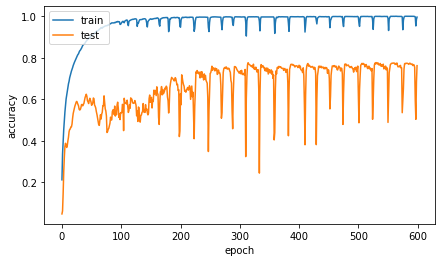

In [18]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [16]:
y_pred = model.predict(testData)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in testData], axis=0)
true_categories = tf.argmax(true_categories, axis=1)

report = classification_report(true_categories, predicted_categories, target_names= class_names, output_dict=True)
print(pd.DataFrame(report).transpose())

              precision    recall  f1-score      support
0              0.384615  0.555556  0.454545    27.000000
1              0.529412  0.818182  0.642857    11.000000
2              0.500000  0.700000  0.583333    10.000000
3              0.888889  0.615385  0.727273    13.000000
4              1.000000  0.666667  0.800000     6.000000
...                 ...       ...       ...          ...
y              0.750000  0.666667  0.705882     9.000000
z              1.000000  0.166667  0.285714     6.000000
accuracy       0.761843  0.761843  0.761843     0.761843
macro avg      0.711957  0.663055  0.663857  1541.000000
weighted avg   0.783891  0.761843  0.760708  1541.000000

[65 rows x 4 columns]


In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(true_categories, predicted_categories)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(true_categories, predicted_categories, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(true_categories, predicted_categories, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(true_categories, predicted_categories, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.761843
Precision: 0.711957
Recall: 0.663055
F1 score: 0.663857


In [14]:
from keras.models import Model
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape


(128, 62)

In [14]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))

In [15]:
cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73728     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512   

In [16]:
features,results = cam_model.predict(testData)
features.shape

(1541, 128)

In [25]:
for idx in range(10):
    features_for_one_img = features[idx,:]
    height_roomout = image_batch.shape[1] / features_for_one_img.shape[0]
    width_roomout = image_batch.shape[2] / features_for_one_img[1]

    cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout), order=2)
    pred= np.argmax(results[idx])

    plt.figure(facecolor='white')
    cam_weights = gap_weights[:, pred]
    cam_output = np.dot(cam_features, cam_weights)

    buf = 'Predicted Class = '+str(pred)+ ', Probability = ' + str(results[idx][pred])
    plt.xlabel(buf)
    plt.imshow(np.squeeze(X_test[idx], -1), alpha=0.5)
    plt.imshow(cam_output, cmap='jet', alpha=0.5)

NameError: name 'sp' is not defined

---
---

OCR
---
+ Resim üzerindeki karakterlerin algılanması <br>
    + otsu_threshold <br>

    <img src="https://www.learnopencv.com/wp-content/uploads/2020/06/processed_img-1-1024x685.jpg" width="350" height="300" /> -> <img src="https://www.learnopencv.com/wp-content/uploads/2020/06/otsu_result-1024x685.png" width="350" height="300" />
    + contours <br>
     <img src="https://i.stack.imgur.com/x3SV0.png" width="200" height="100" />

    + dilate <br>
    <img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/j.png" width="100" height="100" /> -> <img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/dilation.png" width="100" height="100" />

    + padding <br>
    <img src="https://i.imgur.com/UCNn9gd.png" width="14" height="54"/> -> <img src="https://i.imgur.com/56k5F8i.png" width="64" height="64" />
+ Algılanan karakterlerin modelde tahmin edilmesi

In [ ]:
# load image
img = cv2.imread("test2.jpg")

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV) 

# Specify structure shape and kernel size.  
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 8)) 
  
# Appplying dilation on the threshold image 
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
  
# Finding contours 
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

contours = sort_contours(contours, method="left-to-right")[0]

# Creating a copy of image 
im2 = gray.copy() 

text= []
  
# Looping through the identified contours 
for cnt in contours: 
    x, y, w, h = cv2.boundingRect(cnt) 

    # Drawing a rectangle on copied image 
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 1) 
    
    # Cropping the text block for giving input to OCR 
    cropped = gray[y:y + h, x:x + w] 
    
    thresh = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    (tH, tW) = thresh.shape

    # if the width is greater than the height, resize along the
    # # width dimension
    if tW > tH:
        thresh = imutils.resize(thresh, width=32)
    # otherwise, resize along the height
    else:
	    thresh = imutils.resize(thresh, height=32)

    # re-grab the image dimensions (now that its been resized)
    # and then determine how much we need to pad the width and
    # height such that our image will be 32x32
    (tH, tW) = thresh.shape
    dX = int(max(0, 32 - tW) / 2.0)
    dY = int(max(0, 32 - tH) / 2.0)    
    
    # pad the image and force 32x32 dimensions
    padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    padded = cv2.resize(padded, (32, 32))
    
    # prepare the padded image for classification via our
    # handwriting OCR model
    padded = padded.astype("float32") / 255.0
    padded = np.expand_dims(padded, axis=-1)

    # update our list of characters that will be OCR'd
    text.append((padded, (x, y, w, h)))
    plt.imshow(padded, cmap='gray')
    plt.show()


In [ ]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in text]
chars = np.array([c[0] for c in text], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

In [ ]:
result = []
for (pred, (x, y, w, h)) in zip(preds, boxes): 	
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = class_names[i]

	# draw the prediction on the image
	print(f"Predict >> {label} - {prob * 100:.2f}%")
	result.append(label)

# show the image
plt.imshow(img)
plt.show()

In [ ]:
for i in result:
    print(i, end='')